In [33]:
# Import packages
import json
from huggingface_hub import login
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer, pipeline, Trainer, TrainingArguments
import transformers
import random
import torch
import time
import re
from tqdm import tqdm
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import cuda
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import argparse

# Ensure reproducibility
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)  # For multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [34]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Prognosis"], padding="max_length", truncation=True, max_length = 512)

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert logits to probabilities
    probs = softmax(logits, axis=1)

    # Convert labels to one-hot encoding
    labels_one_hot = label_binarize(labels, classes=[0, 1, 2])  # Ensure class order matches label mapping

    # Compute accuracy
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    # Compute multi-class AUC
    auc_roc_score = roc_auc_score(labels_one_hot, probs, multi_class="ovr")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_roc_score
    }

def plot_metrics(labels, predictions, probs, dataset_name, model_name):
    # Define mappings for the dataset and model to human-readable names
    dataset_map = {
        "../Data/subject-info-cleaned-with-prognosis-D-Llama3B.csv": "Llama3B",
        "../Data/subject-info-cleaned-with-prognosis-D-Llama8B.csv": "Llama8B",
    }
    model_map = {
        "dmis-lab/biobert-base-cased-v1.1": "BioBERT",
        "emilyalsentzer/Bio_ClinicalBERT": "ClinicalBERT",
    }

    # Extract readable LLM and LM names
    #dataset_filename = os.path.basename(dataset_name)
    # llm_name = dataset_map.get(dataset_name, "UnknownLLM")
    # lm_name = model_map.get(model_name, "UnknownLM")
    llm_name = 'Llama3B'
    lm_name = 'ClinicalBERT'
    
    # Title and filename prefix
    title_prefix = f"{llm_name} + {lm_name}"
    model_filename = model_name.replace("/", "_")
    #plot_prefix = f"{dataset_filename.replace('.csv', '')}_{model_filename}"
    
    # Plot AUROC
    labels_one_hot = label_binarize(labels, classes=[0, 1, 2])
    class_names = ["Survivor", "Sudden Cardiac Death", "Pump Failure Death"]
    
    plt.figure(figsize=(8, 6))
    
    for i in range(3):
        fpr, tpr, _ = roc_curve(labels_one_hot[:, i], probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")
    
    # Random guess line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} Multi-Class AUROC")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"{title_prefix}_auroc_plot.png")
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {title_prefix}")
    plt.savefig(f"{title_prefix}_confusion_matrix.png")
    plt.show()

In [35]:
# User arguments
# parser = argparse.ArgumentParser(description="Process dataset and model name.")
# parser.add_argument("dataset_path", type=str, help="Path to the dataset CSV file") # Datasets: ../Data/subject-info-cleaned-with-prognosis-D-Llama3B.csv, ../Data/subject-info-cleaned-with-prognosis-D-Llama8B.csv
# parser.add_argument("model_name", type=str, help="Name of the pre-trained model") # Models: dmis-lab/biobert-base-cased-v1.1, emilyalsentzer/Bio_ClinicalBERT
# args = parser.parse_args()
dataset = '../Data/subject-info-cleaned-with-prognosis-D-Llama3B.csv'
model_name = 'emilyalsentzer/Bio_ClinicalBERT'

# Set GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Import data
df = pd.read_csv(dataset)

# Get patient ID, prognosis, and outcome
df = df[['Patient ID', 'Prognosis', 'Outcome']]

# Map labels to integers
label_map = {"survivor": 0, "sudden cardiac death": 1, "pump failure death": 2}
df['Outcome'] = df['Outcome'].map(label_map)
df.rename(columns={"Outcome": "labels"}, inplace=True)

# Convert to Hugging Face Dataset format
dataset = Dataset.from_pandas(df)

# Load BioBERT (or any specified model)
num_labels = 3  # Three possible outcomes
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Split data
train_test = dataset.train_test_split(test_size=0.2, seed = 0)
train_dataset = train_test["train"]
val_dataset = train_test["test"]

# Get patient IDs of train and validation sets
train_indices = train_dataset["Patient ID"]
val_indices = val_dataset["Patient ID"]

# Prepare the data to store
index_data = {
    "train_indices": train_indices,
    "val_indices": val_indices
}

# Save to JSON
with open("split_indices.json", "w") as f:
    json.dump(index_data, f)

# Define training arguments
training_args = TrainingArguments(
    output_dir="../Results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="../logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

# Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics
)
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(eval_results)

# Save evaluation metrics
# metrics_filename = f"{os.path.basename(dataset).replace('.csv', '')}_{model_name.replace('/', '_')}_metrics.json"
# with open(metrics_filename, "w") as f:
#     json.dump(eval_results, f, indent=4)

# Generate predictions for both the training and validation sets
train_predictions_output = trainer.predict(train_dataset)
train_logits = train_predictions_output.predictions
train_predictions = np.argmax(train_logits, axis=-1)
train_probs = softmax(train_logits, axis=1)
train_labels = np.array(train_dataset["labels"])

# Generate predictions for the validation set (same as before)
val_predictions_output = trainer.predict(val_dataset)
val_logits = val_predictions_output.predictions
val_predictions = np.argmax(val_logits, axis=-1)
val_probs = softmax(val_logits, axis=1)
val_labels = np.array(val_dataset["labels"])

# Save the predictions for knowledge distillation (both training and testing predictions)
prediction_output = {
    "train_logits": train_logits.tolist(),
    "train_predictions": train_predictions.tolist(),
    "train_probs": train_probs.tolist(),
    "train_labels": train_labels.tolist(),
    "val_logits": val_logits.tolist(),
    "val_predictions": val_predictions.tolist(),
    "val_probs": val_probs.tolist(),
    "val_labels": val_labels.tolist()
}

# Save predictions to disk (both training and testing predictions)
# with open(f"{os.path.basename(dataset).replace('.csv', '')}_{model_name.replace('/', '_')}_predictions.json", "w") as f:
#     json.dump(prediction_output, f, indent=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 2117.01 examples/s]
/home/sswee/myenv/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2055597/299563860.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.406700,0.423857,0.870588,0.893233,0.870588,0.836115,0.829910
2,0.527100,0.536545,0.829412,0.821127,0.829412,0.807563,0.866305
3,0.152500,0.410216,0.876471,0.861579,0.876471,0.858382,0.879629


{'eval_loss': 0.41021642088890076, 'eval_accuracy': 0.8764705882352941, 'eval_precision': 0.8615793714746173, 'eval_recall': 0.8764705882352941, 'eval_f1': 0.8583823529411765, 'eval_auc': 0.8796288087332863, 'eval_runtime': 1.4101, 'eval_samples_per_second': 120.555, 'eval_steps_per_second': 15.601, 'epoch': 3.0}


emilyalsentzer/Bio_ClinicalBERT


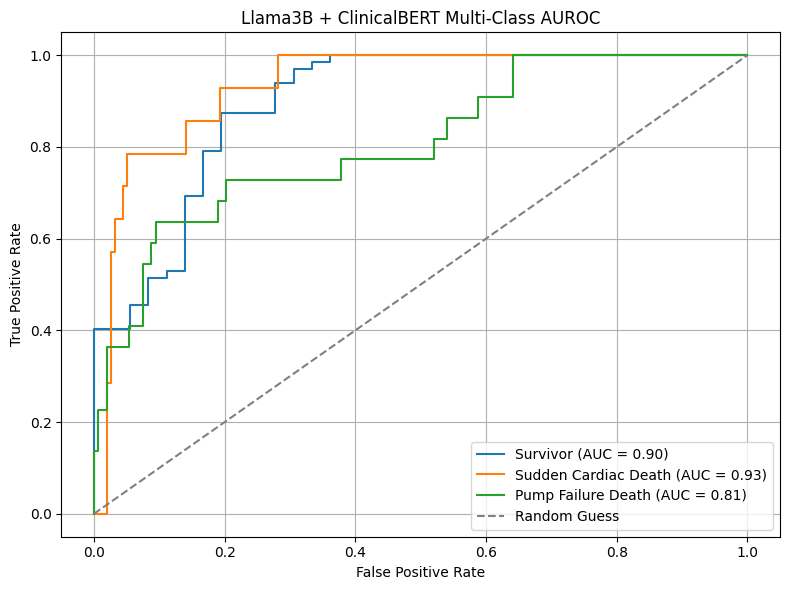

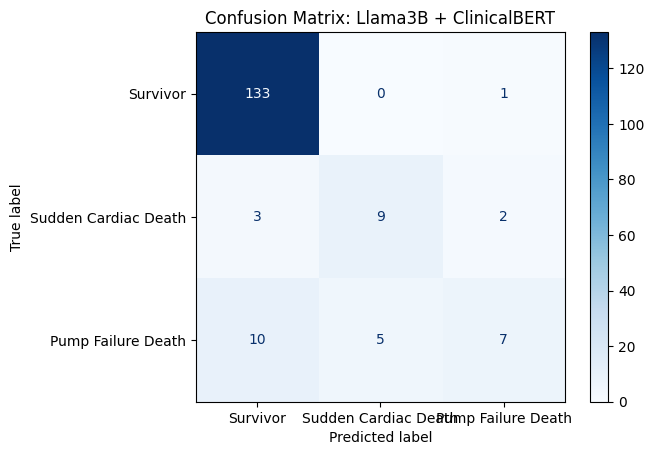

In [36]:
print(model_name)
plot_metrics(val_labels, val_predictions, val_probs, dataset, model_name)